<table width="100%">
  <tr>
    <td>
      <h1 style="text-align: left; font-size:300%;">Homework 2 - Time Series forecasting challenge</h1>
      <table align="left">
        <tr>
          <td style="text-align: left;">Bottazzi Daniele</td>
          <td style="text-align: left;"><a href="mailto:nouhaila.benhdidou@mail.polimi.it">daniele.bottazzi@mail.polimi.it</a></td>
        </tr>
        <tr>
          <td style="text-align: left;">Resta Sara</td>
          <td style="text-align: left;"><a href="mailto:daniele.bottazzi@mail.polimi.it">sara.resta@mail.polimi.it</a></td>
        </tr>
        <tr>
          <td style="text-align: left;">Saldarini Gaia</td>
          <td style="text-align: left;"><a href="mailto:annalisa.imperiali@mail.polimi.it">gaia.saldarini@mail.polimi.it</a></td>
        </tr>
      </table>
    </td>
    <td width="20%">
      <div style="text-align: right">
          <br>
        <b style="font-size: 120%;">AN2DL course</b><br>
        <b>a.y. 2023-2024</b>
          <br><br>
        prof. M. Matteucci<br>
        prof. G. Boracchi<br>
      </div>
    </td>
  </tr>
</table>

# Ensemble of forecasting models according to the clustering of the latent representation
 Link to dowload the `filtered_datasets` used in this Notebook: [link](https://drive.google.com/drive/folders/1FuVLBucfEEDN3pPuNTSgjwv6_3Rstn_4?usp=sharing).

In this homework you are asked to predict future samples of the input time series. The goal is to design and implement forecasting models to learn how to exploit past observations in the input sequences to correctly predict the future. The task is to develop a forecasting model that is able to predict several uncorrelated time series.

The prerequisite is that the model exhibits generalisation capabilities in the forecasting domain, allowing it to transcend the constraints of specific time domains. This requires a model that, while specialised in forecasting, is not limited to predicting in a single or predefined time context.

Categories are not taken into account anymore since they don't divide series into meaningful groups. The idea is to cluster similar series and create a different model for each cluster. Clustering on vanilla valid series was tried but was not meaningful; a different method may cluster series based on their compact latent representations, which are found by training an auto-encoder model on the valid series.

###Connect to drive and import libraries

In [ ]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive/My Drive/Colab Notebooks/AN2DL/2023-2024/Homework 2

Mounted at /gdrive
/gdrive/My Drive/Colab Notebooks/AN2DL/2023-2024/Homework 2


In [ ]:
# Fix randomness and hide warnings
seed = 42

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['MPLCONFIGDIR'] = os.getcwd()+'/configs/'

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

import numpy as np
np.random.seed(seed)

import logging

import random
random.seed(seed)

In [ ]:
# Import tensorflow
import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)
print(tf.__version__)

2.15.0


In [ ]:
# Import other libraries
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
import seaborn as sns

###Filtered dataset loading and inspection

I use a dataset already filtered for duplicates by DTW.

In [ ]:
# Load dataset
unique_series = np.load('filtered_datasets/filtered_series_02.npy')
unique_valid_periods = np.load('filtered_datasets/filtered_valid_periods_02.npy')

In [ ]:
print(unique_series.shape)
print(unique_valid_periods.shape)

(47048, 2776)
(47048, 2)


In [ ]:
# Longest series check
length = unique_valid_periods[:, 1] - unique_valid_periods[:, 0]

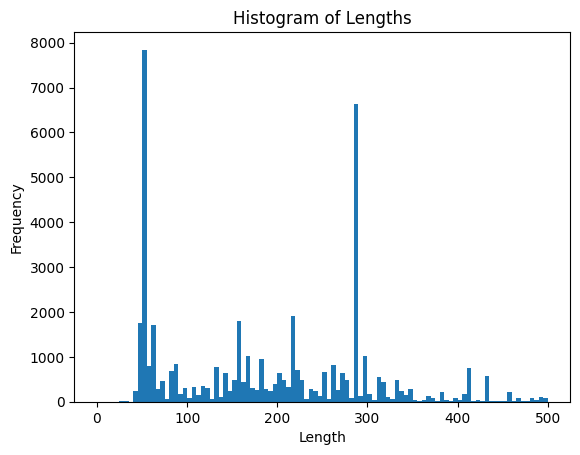

In [ ]:
plt.hist(length, bins=100, range=(0, 500))
plt.xlabel('Length')
plt.ylabel('Frequency')
plt.title('Histogram of Lengths')
plt.show()

In [ ]:
elem, count = np.unique(length, return_counts = True)
ascending = np.argsort(count)
descending = ascending[::-1]
idx = descending[0:3]
elem[idx]

array([ 51, 288, 157])

In [ ]:
sum(length < 48)

383

In [ ]:
idx = (length >= 48)
new = unique_series[idx]
length = length[idx]
length.shape

(46665,)

The mode of the series length is 51, and only 383 are shorter than 48. We consider only sequences shorter than 48 to avoid too much padding, which would bias the results both in the clustering based on hidden vectors and in building the sequences from the series, used by the forecasting model.

To gain the best accurate clustering and model performance, I divide my dataset only in training and validation, so that they see all the provided series.

In [ ]:
series_train, series_val, length_train, length_val = train_test_split(new, length, random_state=seed, test_size=0.1)
print(series_train.shape)
print(series_val.shape)

(41998, 2776)
(4667, 2776)


In [ ]:
del new, length, unique_valid_periods, unique_series, ascending, descending

In the auto-encoder model, to avoid padding, I consider for all series the last 48 values.

In [ ]:
X_new_train = series_train[:, -48:]
X_new_val = series_val[:, -48:]
print(X_new_train.shape)
print(X_new_val.shape)

(41998, 48)
(4667, 48)


## Auto encoder

Hidden vectors are set to length of 10.

In [ ]:
enc_input_shape = (48, 1, )
enc_output_shape = 10
dec_input_shape = enc_output_shape
dec_output_shape = enc_input_shape
n_cols = 1
n_rows = 48
input_shape = enc_input_shape
batch_size = 128
epochs = 200

In [ ]:
def get_encoder():
  input_layer = tfkl.Input(shape=enc_input_shape, name='input_layer')

  # Block of conv+batchnorm+relu
  x = tfkl.Conv1D(64, 3, padding='same', strides=2)(input_layer)
  x = tfkl.BatchNormalization()(x)
  x = tfkl.ReLU()(x)

  # Another block of conv+batchnorm+relu
  # Flattening and a dense layer to the latent_dim
  x = tfkl.Flatten()(x)
  output_layer = tfkl.Dense(enc_output_shape, name='output_layer')(x)
  # The value returned by the output layer is the latent representation

  # Connect input and output through the Model class
  model = tfk.Model(inputs=input_layer, outputs=output_layer, name='encoder')
  return model



In [ ]:
def get_decoder():
  input_layer = tfkl.Input(shape=dec_input_shape, name='input_layer')

  # Add a dense layer from the latent representation to a larger vector
  x = tfkl.Dense(n_rows*n_cols)(input_layer)
  x = tfkl.BatchNormalization()(x)
  x = tfkl.ReLU()(x)

  # Invert the flattening by reshaping
  x = tfkl.Reshape((n_rows, n_cols))(x)

  # Upsampling block: upsampling + convolution + batchnorm + relu
  # x = tfkl.UpSampling1D()(x)
  x = tfkl.Conv1D(128, 3, padding='same')(x)
  x = tfkl.BatchNormalization()(x)
  x = tfkl.ReLU()(x)

  # Another upsampling block: upsampling + convolution + batchnorm + relu
  # the last block is a convolution returning to the image domain
  x = tfkl.Conv1D(dec_output_shape[-1], 3, padding='same')(x)
  output_layer = tfkl.Activation('sigmoid')(x) # by doing so we clip values, 'linear' is also fine

  # Connect input and output through the Model class
  model = tfk.Model(inputs=input_layer, outputs=output_layer, name='decoder')
  return model


Model: "autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 48, 1)]           0         
                                                                 
 encoder (Functional)        (None, 10)                15882     
                                                                 
 decoder (Functional)        (None, 48, 1)             2129      
                                                                 
Total params: 18011 (70.36 KB)
Trainable params: 17531 (68.48 KB)
Non-trainable params: 480 (1.88 KB)
_________________________________________________________________


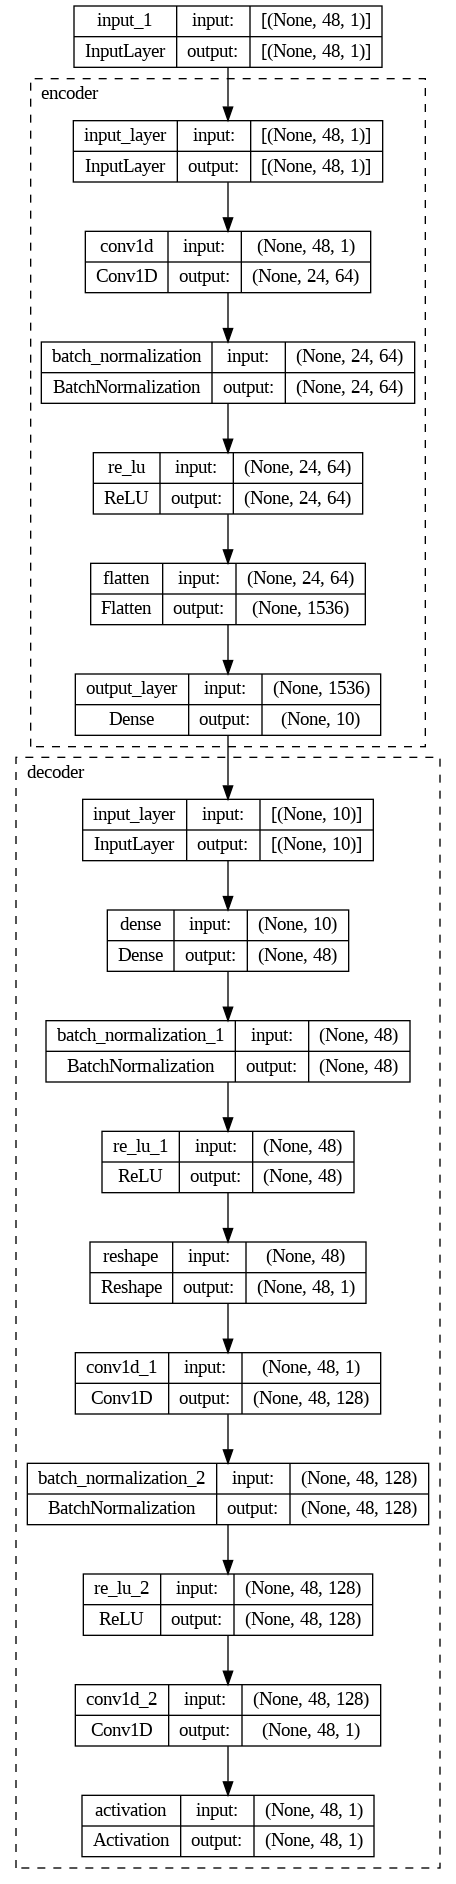

In [ ]:
def get_autoencoder(ae_input_shape=input_shape, ae_output_shape=input_shape):
  tf.random.set_seed(seed)
  # Invoke functions to instantiate models
  encoder = get_encoder()
  decoder = get_decoder()
  # Assemble the network
  input_layer = tfkl.Input(shape=ae_input_shape)
  z = encoder(input_layer)
  output_layer = decoder(z)
  model = tfk.Model(inputs=input_layer, outputs=output_layer, name='autoencoder')
  return model

# Instantiate the autoencoder
autoencoder = get_autoencoder()
autoencoder.summary()
tfk.utils.plot_model(autoencoder, show_shapes=True, expand_nested=True, to_file='autoencoder.png')


In [ ]:
# define training options
learning_rate = 1e-3
optimizer = tf.optimizers.Adam(learning_rate)
# the autoencoder needs to be trained by minimizing a reconstruction loss
autoencoder.compile(optimizer=optimizer, loss=tfk.losses.MeanSquaredError(), metrics=['mse', 'mae'])


In [ ]:
# train the autoencoder
autoencoder.fit(
X_new_train, # the input
X_new_train, # the target for the autoencoder is the input itself
batch_size=batch_size,
epochs=epochs,
validation_data=(X_new_val,X_new_val), # the target for the autoencoder is the input itself
callbacks=[tfk.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=10, restore_best_weights=True),
 tfk.callbacks.ReduceLROnPlateau(monitor='val_loss', patience=5, factor=0.5, min_lr=1e-5),
]
)


Epoch 1/200
329/329 [==============================] - 12s 8ms/step - loss: 0.0149 - mse: 0.0149 - mae: 0.0884 - val_loss: 0.0565 - val_mse: 0.0565 - val_mae: 0.2046 - lr: 0.0010
Epoch 2/200
329/329 [==============================] - 3s 9ms/step - loss: 0.0091 - mse: 0.0091 - mae: 0.0690 - val_loss: 0.0098 - val_mse: 0.0098 - val_mae: 0.0744 - lr: 0.0010
Epoch 3/200
329/329 [==============================] - 3s 8ms/step - loss: 0.0082 - mse: 0.0082 - mae: 0.0643 - val_loss: 0.0087 - val_mse: 0.0087 - val_mae: 0.0673 - lr: 0.0010
Epoch 4/200
329/329 [==============================] - 2s 7ms/step - loss: 0.0076 - mse: 0.0076 - mae: 0.0609 - val_loss: 0.0086 - val_mse: 0.0086 - val_mae: 0.0677 - lr: 0.0010
Epoch 5/200
329/329 [==============================] - 2s 7ms/step - loss: 0.0074 - mse: 0.0074 - mae: 0.0598 - val_loss: 0.0070 - val_mse: 0.0070 - val_mae: 0.0575 - lr: 0.0010
Epoch 6/200
329/329 [==============================] - 2s 7ms/step - loss: 0.0071 - mse: 0.0071 - mae: 0.0581

In [ ]:
embedding = tfk.Sequential(autoencoder.layers[:-1])
embedding.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder (Functional)        (None, 10)                15882     
                                                                 
Total params: 15882 (62.04 KB)
Trainable params: 15754 (61.54 KB)
Non-trainable params: 128 (512.00 Byte)
_________________________________________________________________


In [ ]:
embedding.save('model_embedding_test')

In [ ]:
pred_train = embedding.predict(X_new_train,verbose=0)
pred_val = embedding.predict(X_new_val, verbose = 0)

In [ ]:
pred_tot = np.concatenate([pred_train, pred_val])    # su cui cluster insieme a long!
pred_tot.shape

(46665, 10)

In [ ]:
del pred_train, pred_val

## Clusters

In [ ]:
from sklearn.cluster import KMeans
num_clusters = 3
model = KMeans(n_clusters=num_clusters, init='k-means++', random_state=0)
y_predict = model.fit_predict(pred_tot)
clusters, counts = np.unique(y_predict, return_counts=True)
print(counts)

[18191 20086  8388]


The clustering based on the hidden vectors of the latent space is performed with KMeans; the most meaningful and representative one finds finds 3 groups, which contain a comparable number of samples.

In [ ]:
data_tot = np.concatenate([series_train, series_val])
l = np.concatenate([length_train, length_val])

data_0 = data_tot[y_predict ==0]
data_1 = data_tot[y_predict ==1]
data_2 = data_tot[y_predict ==2]

l0 = l[y_predict ==0]
l1 = l[y_predict ==1]
l2 = l[y_predict ==2]


In [ ]:
# Number of series to display
num_series = 10

def display_series(series, categories=None, num_series=10, last=500):
  fig, axes = plt.subplots(num_series, 1, figsize=(20, num_series * 1.8))
  for i in range(num_series):
      ax = axes[i]
      if categories is not None:
        ax.set_title(categories[i])
      ax.plot(series[i][-last:])

  # Adjust layout and display the images
  plt.tight_layout()
  plt.show()

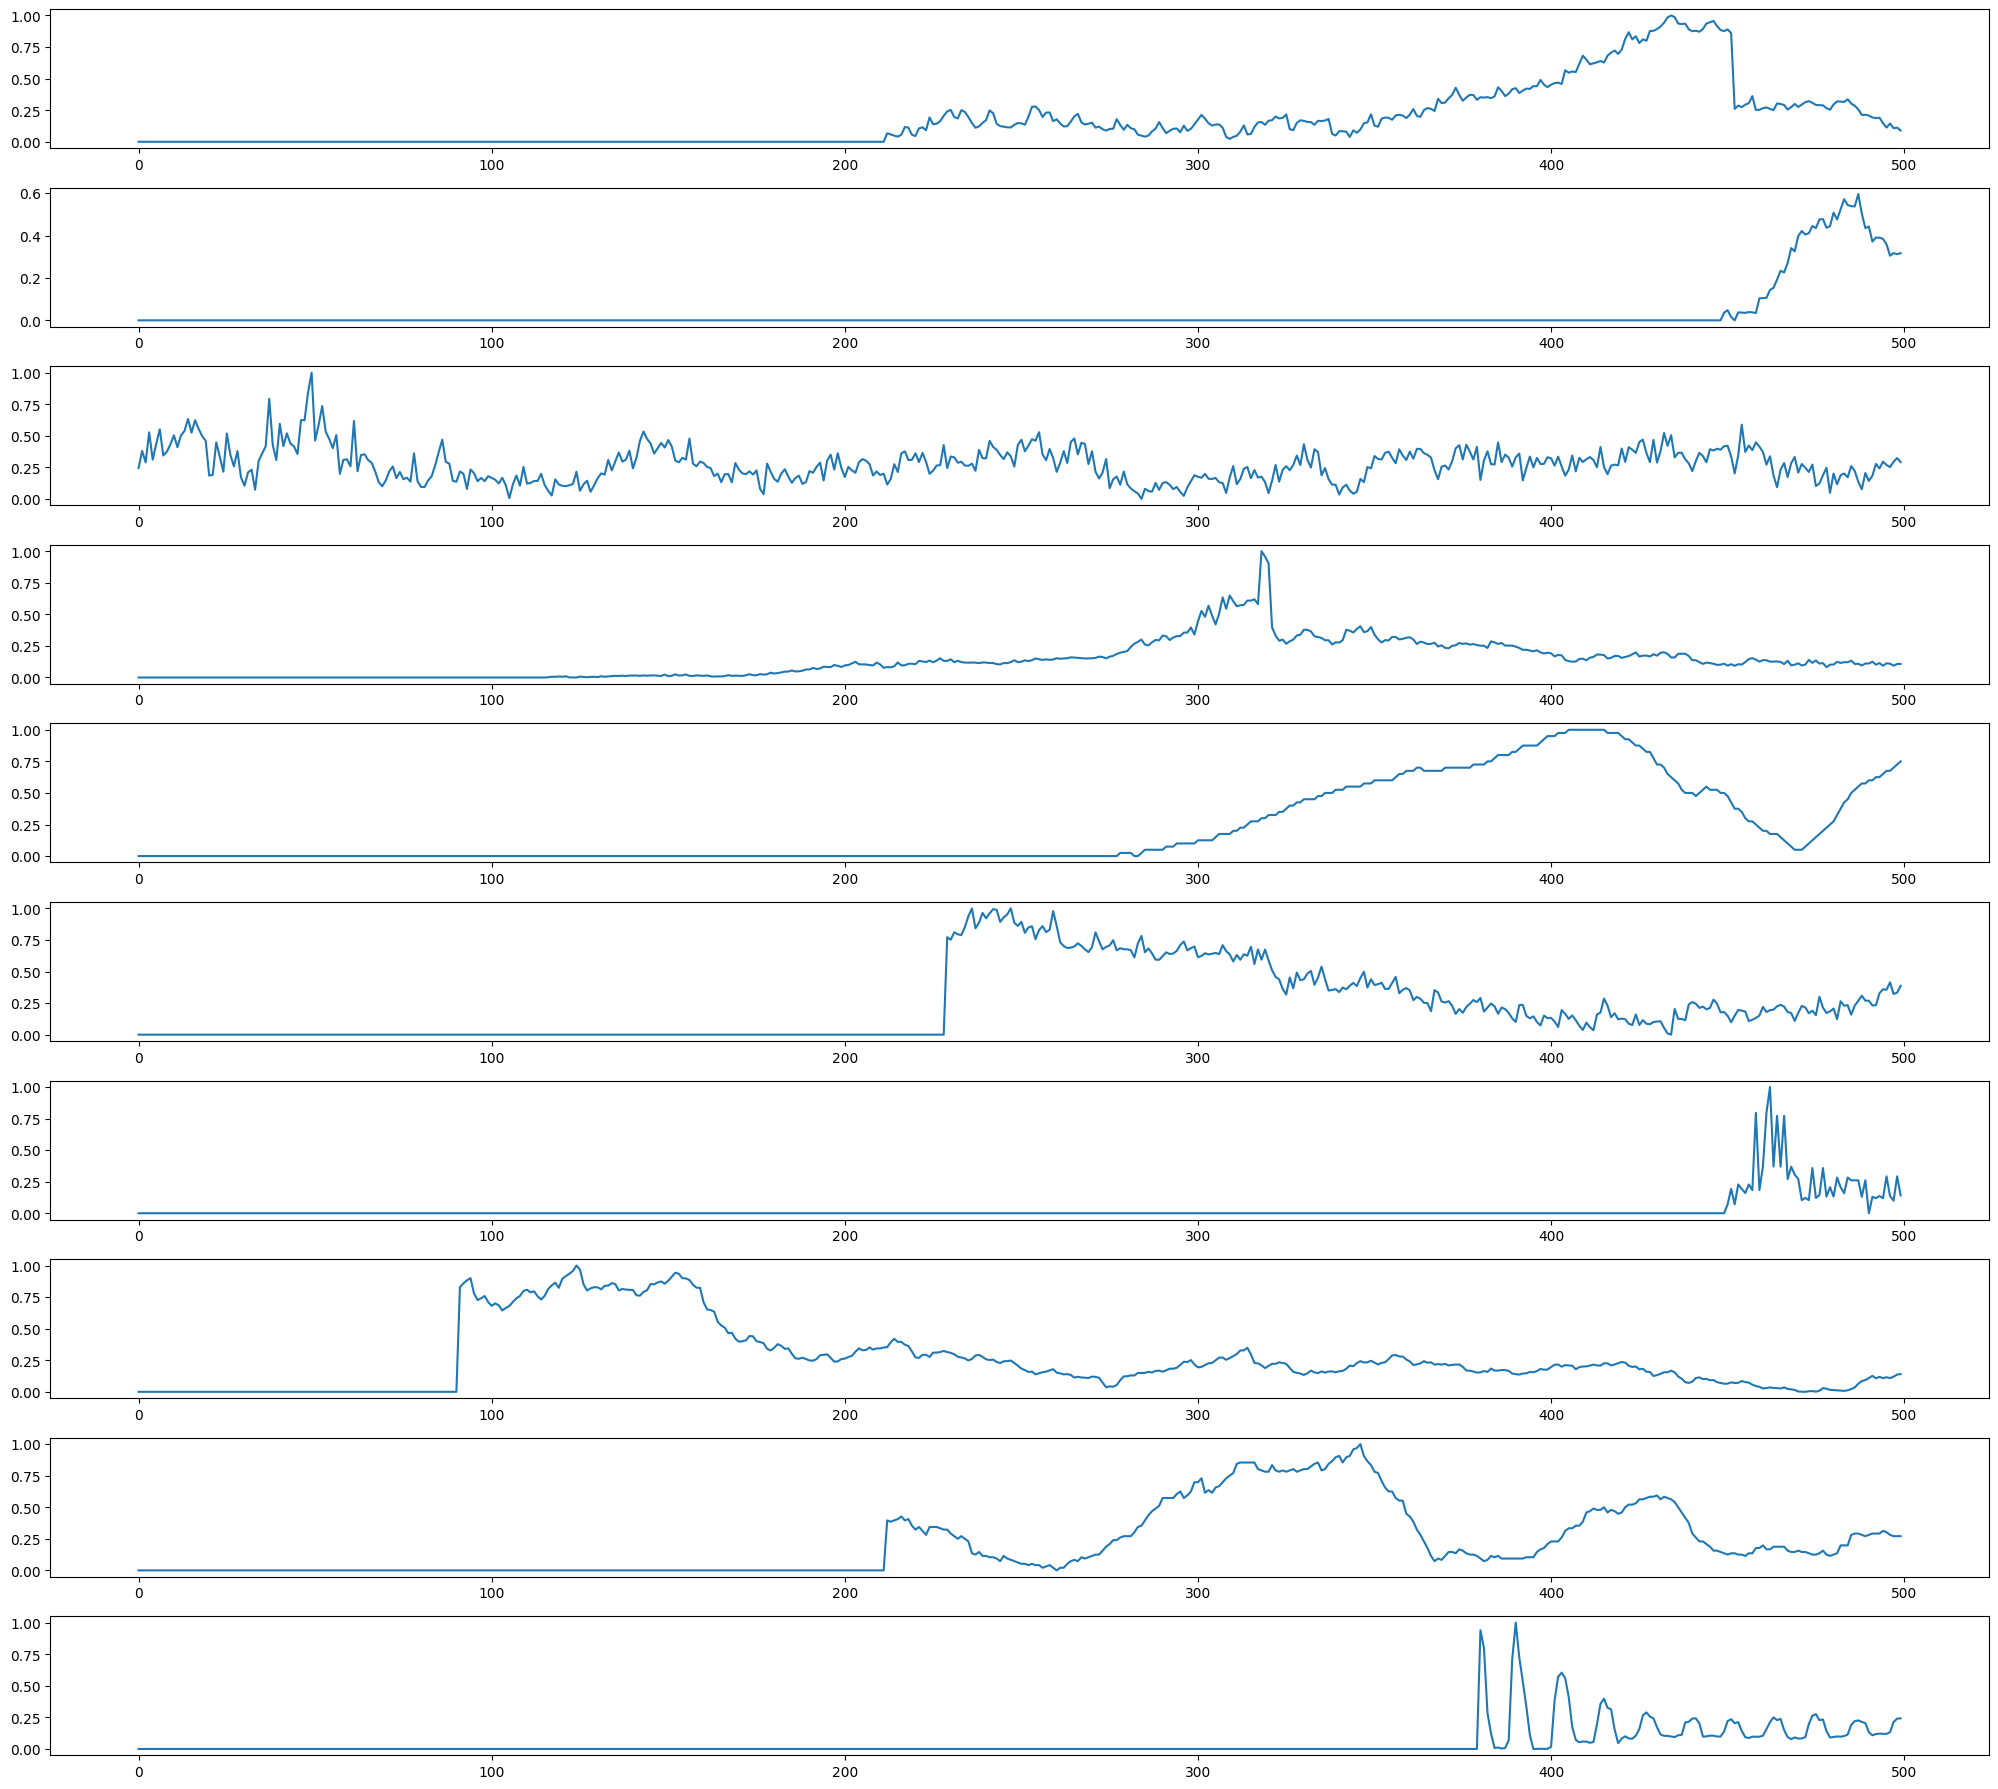

In [ ]:
display_series(data_0)

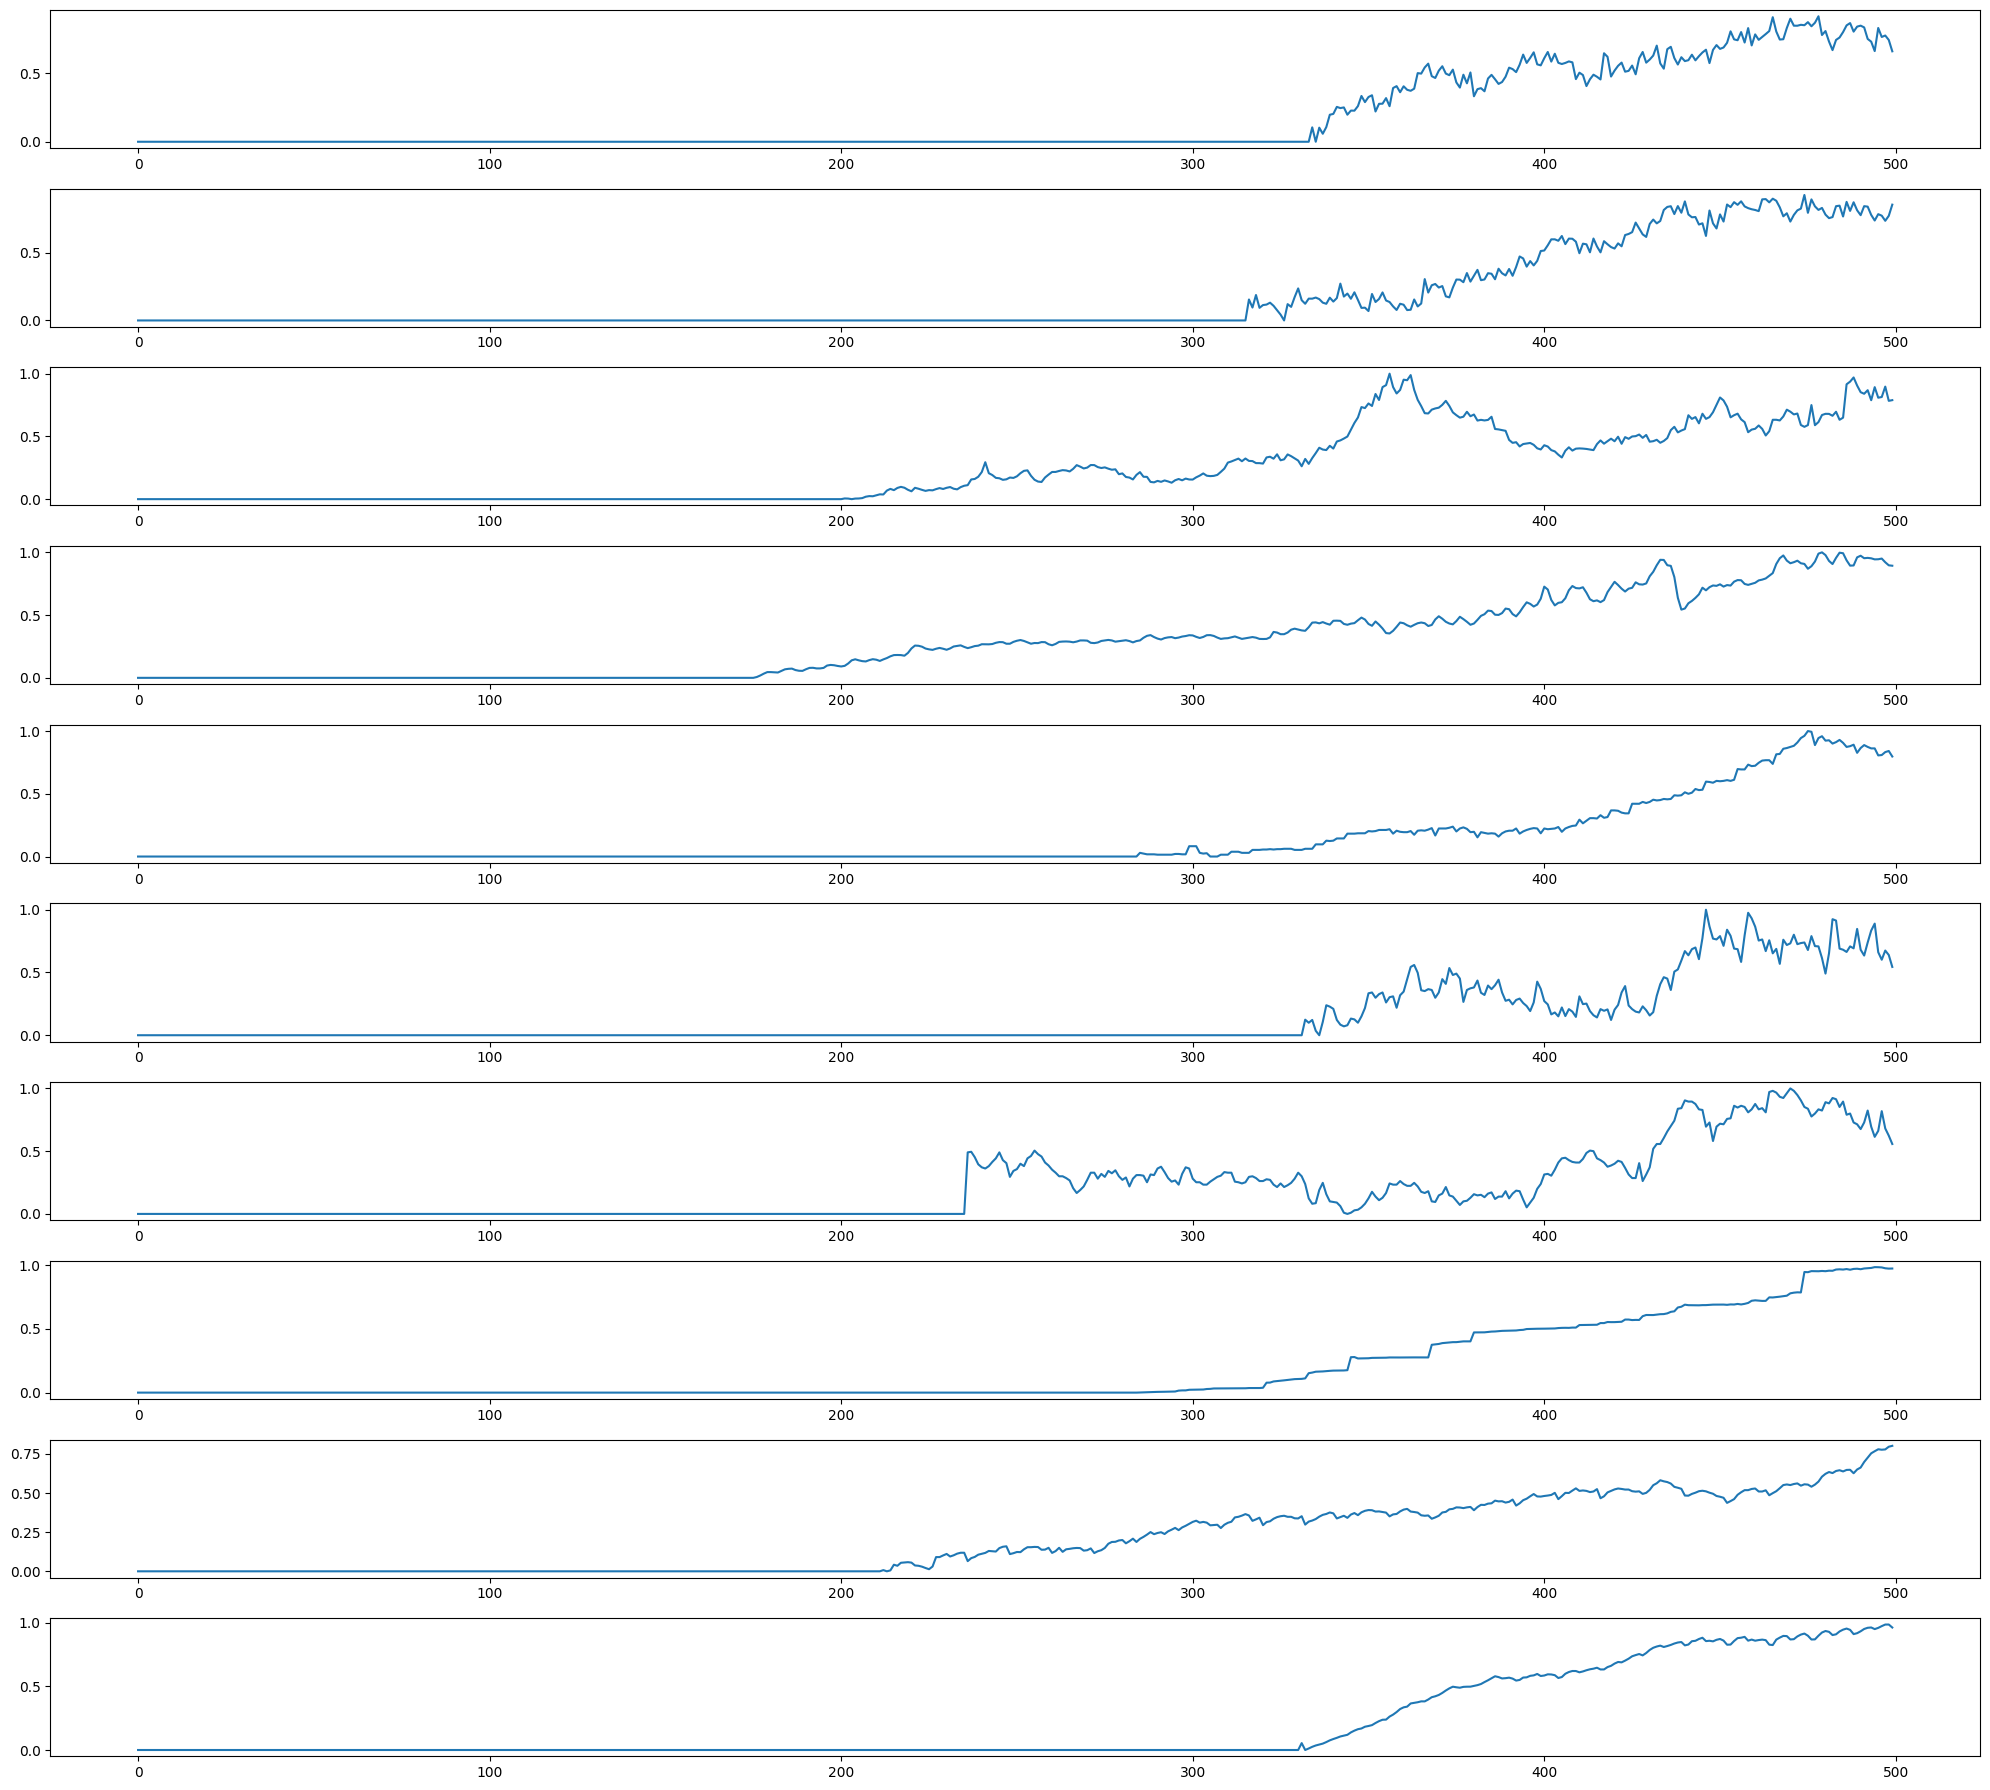

In [ ]:
display_series(data_1)

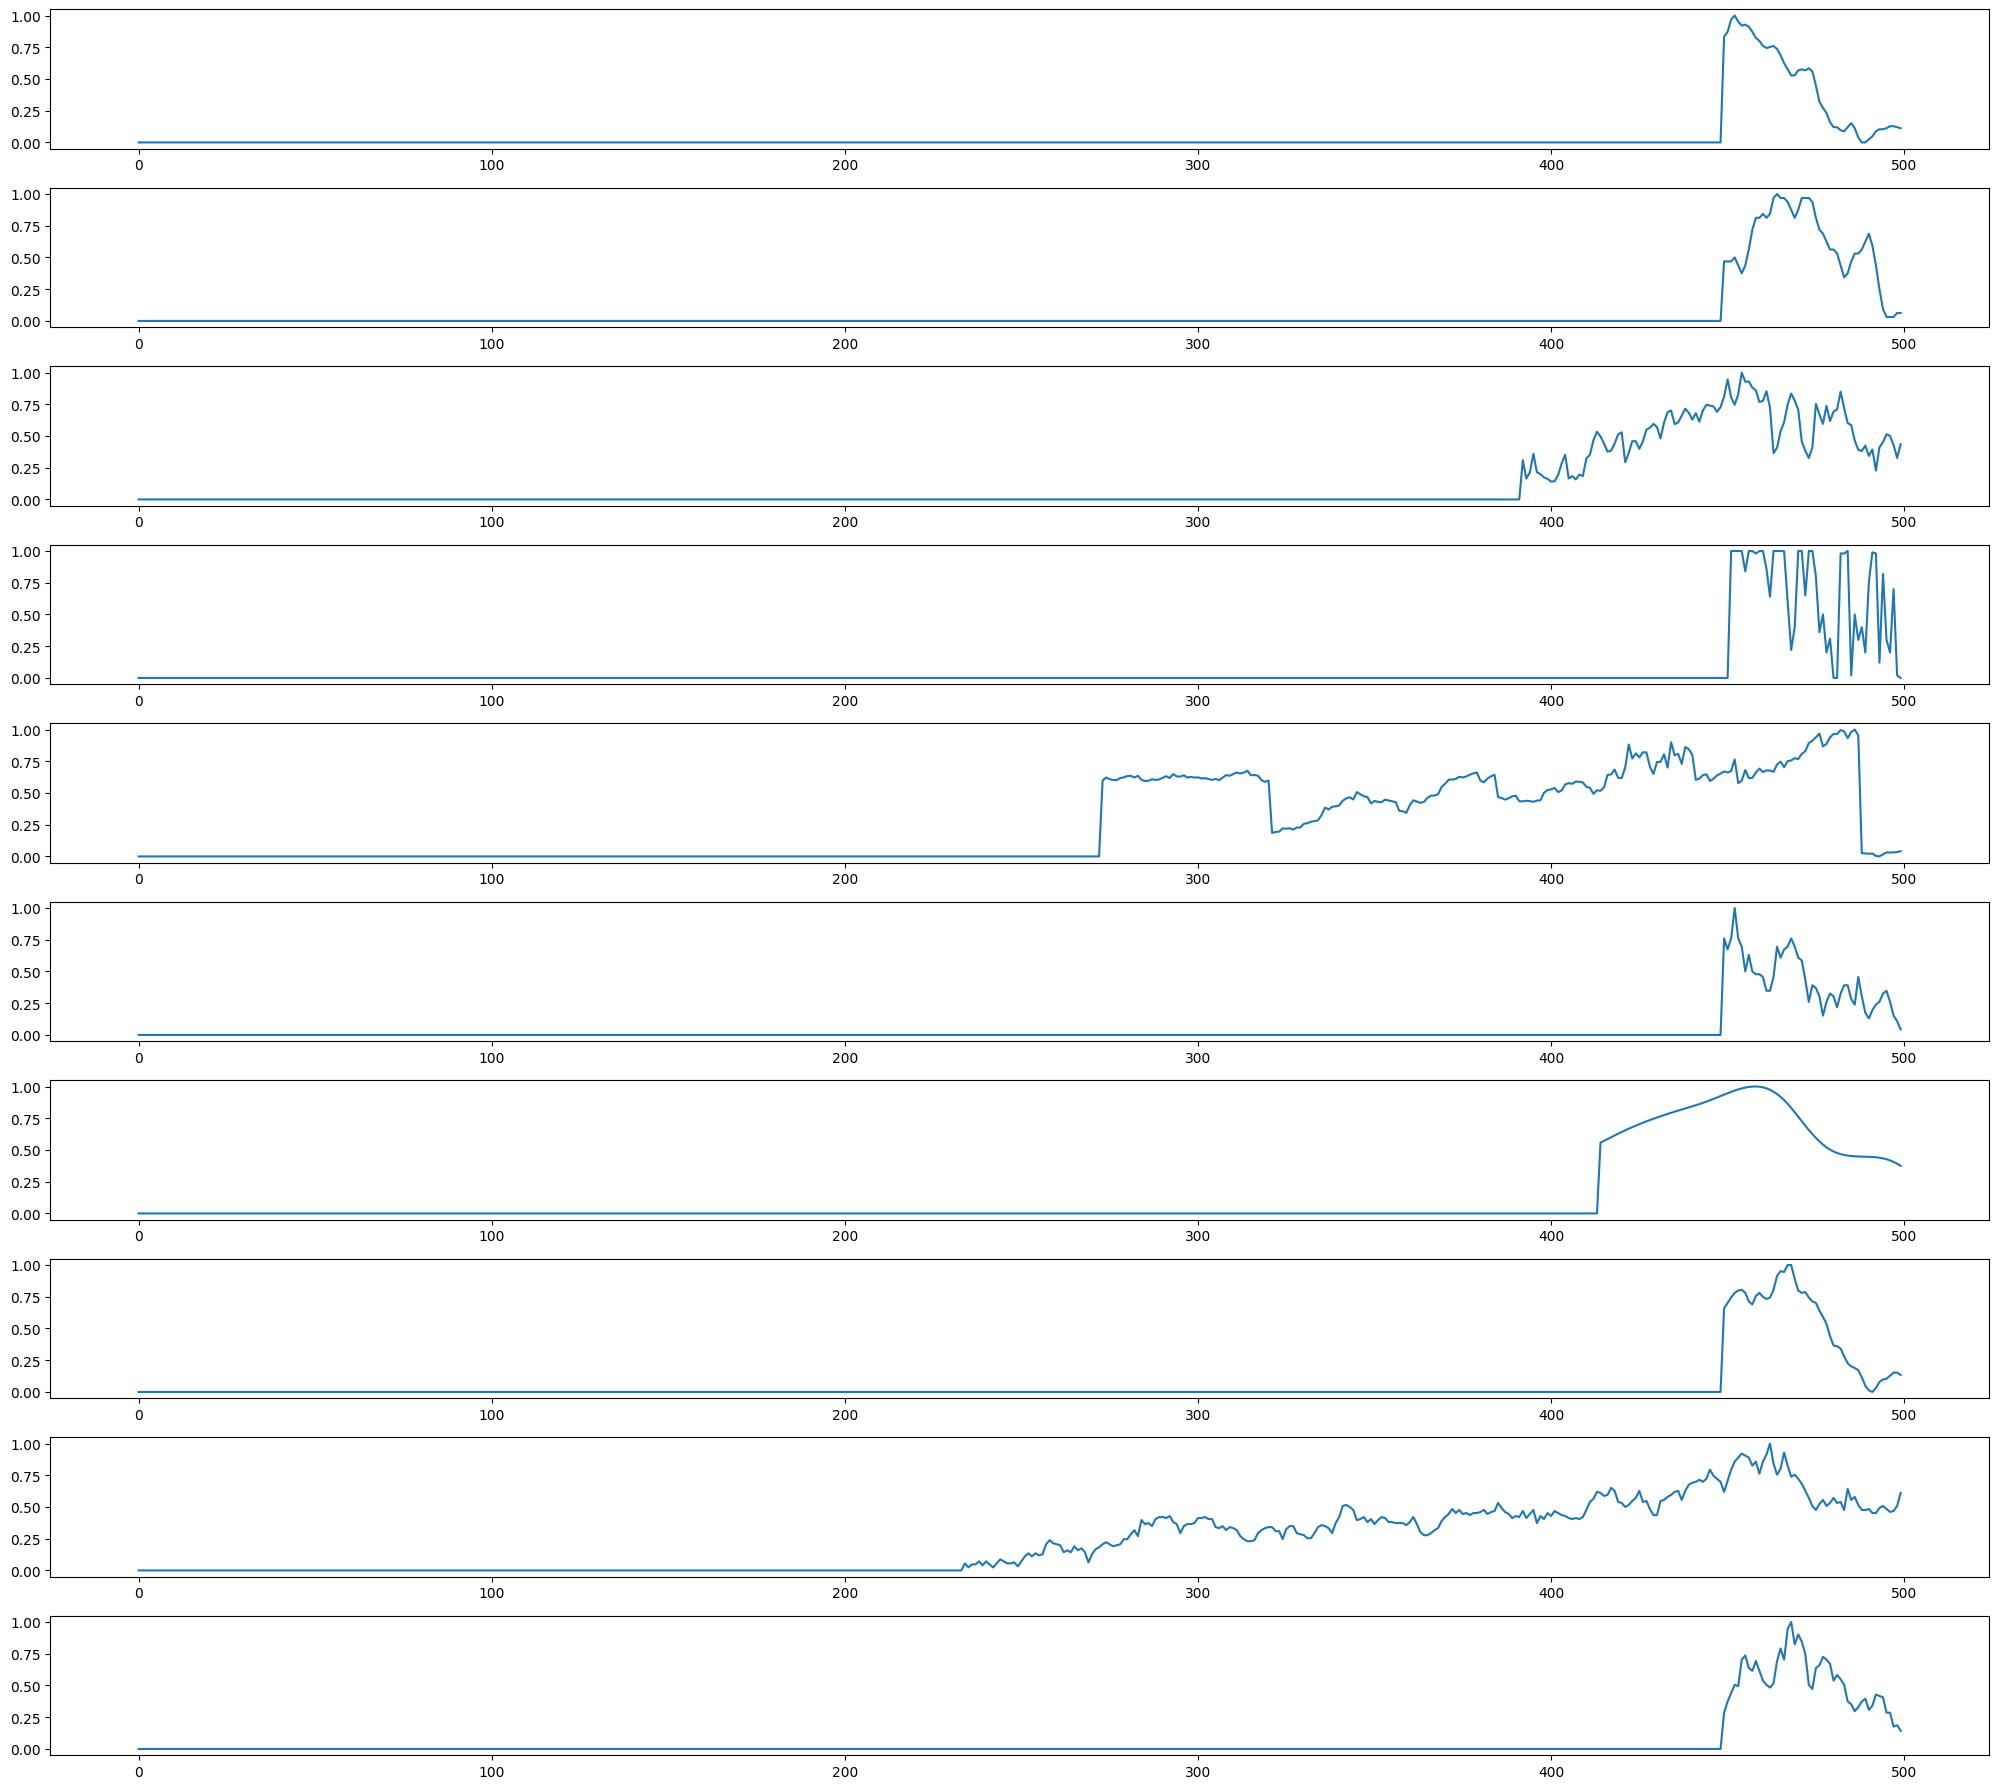

In [ ]:
display_series(data_2)

Results: by inspection, the clusters seem to have learned some patterns in the series. the three clusters can be considered representative of ‘ascending’, ‘descending’ and ‘irregular’ series (spiked, with continuous ups and down and a constant average).

- cluster 0: same average, spiked
- cluster 1: ascending
- cluster 2: descending

Let's look at the average behaviour within each cluster:

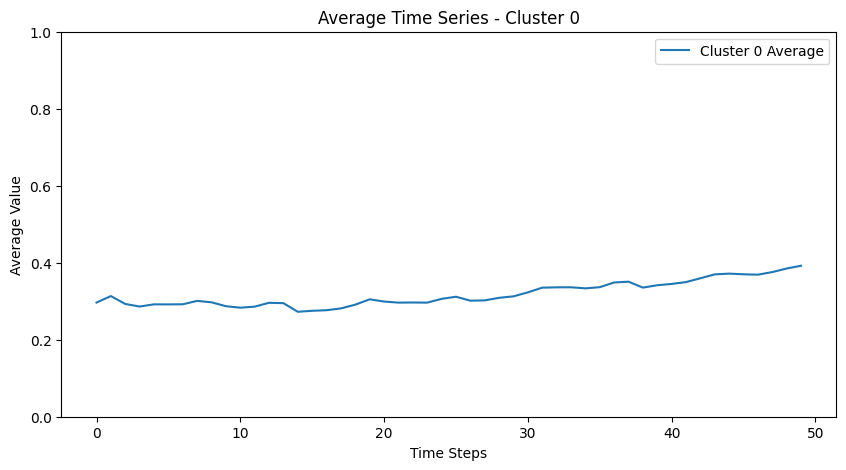

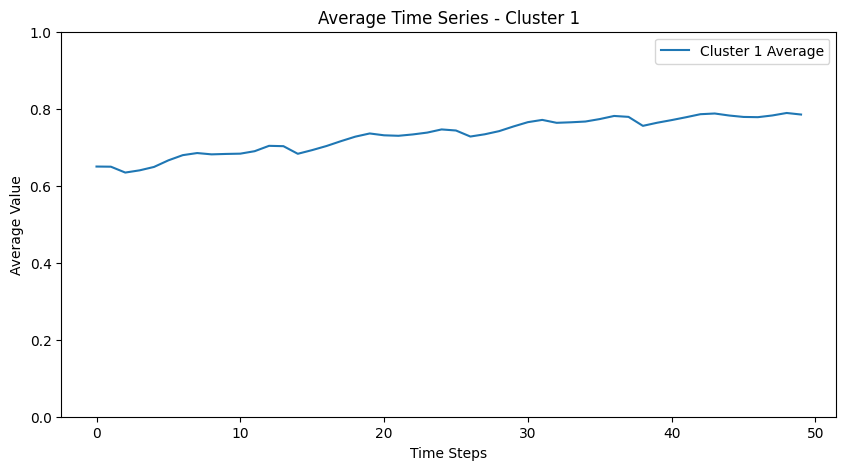

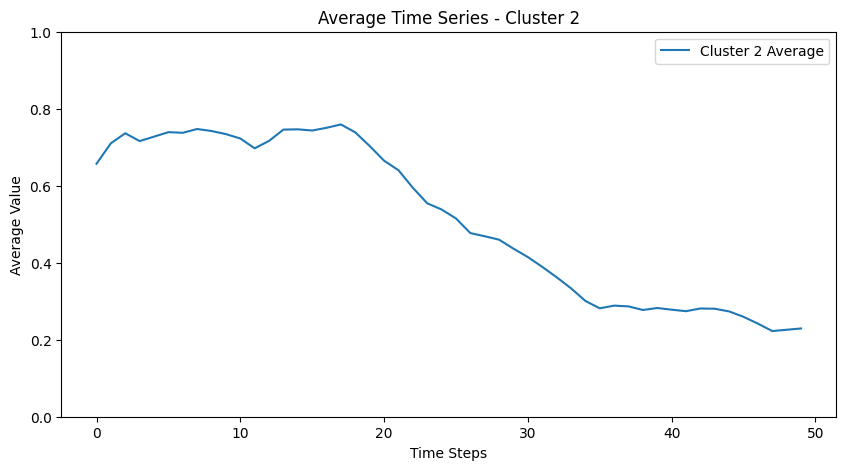

In [ ]:
# Add a new column to your array with cluster labels
clustered_data = np.column_stack((data_tot, y_predict))
last = 50

# Iterate over each cluster and plot the average of all time series in that cluster
for cluster_num in range(0, num_clusters):
    cluster_mask = clustered_data[:, -1] == cluster_num
    cluster_time_series = clustered_data[cluster_mask, :-1]

    # Calculate the mean along the 0th axis (across all time series in the cluster)
    cluster_average = np.mean(cluster_time_series, axis=0)

    # Plot the average time series for the cluster
    plt.figure(figsize=(10, 5))
    plt.plot(cluster_average[-last:], label=f'Cluster {cluster_num} Average')

    plt.title(f'Average Time Series - Cluster {cluster_num}')
    plt.xlabel('Time Steps')
    plt.ylabel('Average Value')
    plt.ylim(0,1)
    plt.legend()
    plt.show()

The average behaviour confirms the patterns: in the case of spiked series, the average is flat since ups and downs cancel each other out.

In [ ]:
np.save('KNN_y.npy', y_predict)
np.save('KNN_x.npy', pred_tot)

In [ ]:
valid_series_0 = np.array([row[-fine:] for row, fine in zip(data_0, l0)])
valid_series_1 = np.array([row[-fine:] for row, fine in zip(data_1, l1)])
valid_series_2 = np.array([row[-fine:] for row, fine in zip(data_2, l2)])

In [ ]:
np.save('medium.npy', valid_series_0)
np.save('ascending.npy', valid_series_1)
np.save('descending.npy', valid_series_2)

# Build 3 models

In [ ]:
print(valid_series_0.shape)
print(valid_series_1.shape)
print(valid_series_2.shape)

(18191,)
(20086,)
(8388,)


In [ ]:
def replicate_array_reverse(original_array, desired_length, period=12):
    original_length = len(original_array)
    period_compliant_array = original_array[(original_length % period):]
    period_compliant_length = len(period_compliant_array)
    replication_factor = desired_length // period_compliant_length
    remainder = desired_length % period_compliant_length

    replicated_array = list(period_compliant_array[::-1]) * replication_factor + list(period_compliant_array[::-1][:remainder])

    return np.array(replicated_array[::-1])

In [ ]:
def build_sequences_univariate(series_array, window=66, stride=22, telescope=18):

    # Sanity check to avoid runtime errors
    assert window % stride == 0
    sequences = []
    future_sequences = []

    for (i, series) in enumerate(series_array):
        series_len = len(series)
        diff = series_len -window -telescope
        s = series

        if (diff <= 0):
          s = replicate_array_reverse(s, window + telescope)
          assert len(s) == (window + telescope)

        for idx in np.arange(len(s) - window - telescope, -1, -stride):
          # Get a slice of window + telescope of the series
          series_xy = s[idx:idx + window + telescope]

          # Get x
          series_x = series_xy[0:window]

          # Add to the sequences
          sequences.append(series_x)

          # Get y
          series_y = series_xy[window:window+telescope]

          # Add to future sequences
          future_sequences.append(series_y)

    sequences = np.array(sequences)
    future_sequences = np.array(future_sequences)

    return sequences, future_sequences

In [ ]:
window = 48
stride = 16
telescope = 18
direct_telescope = telescope

The aim is to forecast next 18 values, so telescope = 18. The parameters that need to be tuned are stride and window (which should be a multiple of stride so that the sequences starting points are equally positioned). We put much attention in defining these parameters in a logic way so that the built sequences would be as meaningful as possible to learn the features of the series. First, it must be considered that most series are short, therefore big windows would introduce much padding. Second, considering the 12-periodicity, we want to be able to see the seasonality pattern from many equally spaced starting points, so that the behaviour can be learnt even if the pattern is not centered in the window: to do this, the stride should be bigger than 12 (ex to see the see the seasonality pattern from 3 points of view, a stride of 16 is needed). Lastly, to avoid unnecessary padding and given the high number of provided series, we built sequences starting from the most recent one going backward till was possible without padding; this was added only to make sure that we took at least one sequence from each series.

In [ ]:
X_train_val_0, y_train_val_0 = build_sequences_univariate(valid_series_0, window = window, stride = stride, telescope = direct_telescope)
X_train_val_1, y_train_val_1 = build_sequences_univariate(valid_series_1, window = window, stride = stride, telescope = direct_telescope)
X_train_val_2, y_train_val_2 = build_sequences_univariate(valid_series_2, window = window, stride = stride, telescope = direct_telescope)

In [ ]:
X_train_0, X_val_0, y_train_0, y_val_0 = train_test_split(X_train_val_0, y_train_val_0, random_state=seed, shuffle = True, test_size=0.1)
X_train_1, X_val_1, y_train_1, y_val_1 = train_test_split(X_train_val_1, y_train_val_1, random_state=seed, shuffle = True, test_size=0.1)
X_train_2, X_val_2, y_train_2, y_val_2 = train_test_split(X_train_val_2, y_train_val_2, random_state=seed, shuffle = True, test_size=0.1)

In [ ]:
def build_CONV_LSTM_model(input_shape, output_shape):
    # Ensure the input time steps are at least as many as the output time steps
    assert input_shape[0] >= output_shape[0], "For this exercise we want input time steps to be >= of output time steps"

    # Define the input layer with the specified shape
    input_layer = tfkl.Input(shape=input_shape, name='input_layer')

    # Add a Bidirectional LSTM layer with 64 units
    x = tfkl.Bidirectional(tfkl.LSTM(64, return_sequences=True, name='lstm'), name='bidirectional_lstm')(input_layer)

    x = tfkl.MultiHeadAttention(num_heads=8, key_dim=1)(x, x, x)

    # Add a 1D Convolution layer with 128 filters and a kernel size of 3
    x = tfkl.Conv1D(128, 3, padding='same', activation='relu', name='conv')(x)

    # Add a final Convolution layer to match the desired output shape
    output_layer = tfkl.Conv1D(output_shape[1], 3, padding='same', name='output_layer')(x)

    # Calculate the size to crop from the output to match the output shape
    crop_size = output_layer.shape[1] - output_shape[0]

    # Crop the output to the desired length
    output_layer = tfkl.Cropping1D((0, crop_size), name='cropping')(output_layer)

    # Construct the model by connecting input and output layers
    model = tf.keras.Model(inputs=input_layer, outputs=output_layer, name='CONV_LSTM_model')

    # Compile the model with Mean Squared Error loss and Adam optimizer
    model.compile(loss=tf.keras.losses.MeanAbsoluteError(), optimizer=tf.keras.optimizers.Adam(learning_rate=2e-3))

    return model

##Model 1: noisy, same average

In [ ]:
X_train_0 = np.expand_dims(X_train_0, axis=-1)
X_val_0 = np.expand_dims(X_val_0, axis=-1)

y_train_0 = np.expand_dims(y_train_0, axis=-1)
y_val_0 = np.expand_dims(y_val_0, axis=-1)

In [ ]:
input_shape  = X_train_0.shape[1:]
output_shape = y_train_0.shape[1:]
batch_size = 32
epochs = 200

In [ ]:
print(X_train_0.shape)

(141791, 48, 1)


Model: "CONV_LSTM_model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_layer (InputLayer)    [(None, 48, 1)]              0         []                            
                                                                                                  
 bidirectional_lstm (Bidire  (None, 48, 128)              33792     ['input_layer[0][0]']         
 ctional)                                                                                         
                                                                                                  
 multi_head_attention_1 (Mu  (None, 48, 128)              4248      ['bidirectional_lstm[0][0]',  
 ltiHeadAttention)                                                   'bidirectional_lstm[0][0]',  
                                                                     'bidirectional_

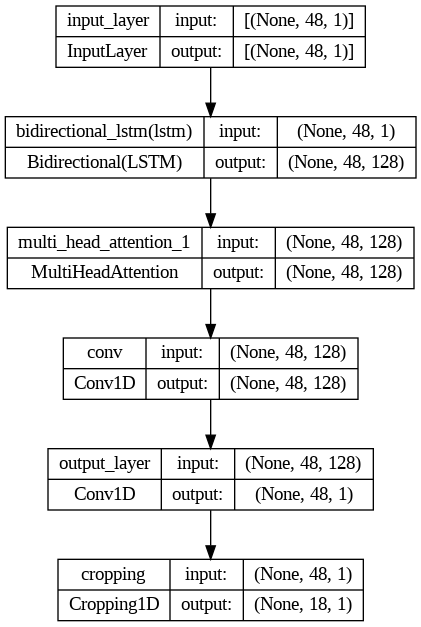

In [ ]:
model = build_CONV_LSTM_model(input_shape, output_shape)
model.summary()
tfk.utils.plot_model(model, expand_nested=True, show_shapes=True)

In [ ]:
history = model.fit(
    x = X_train_0,
    y = y_train_0,
    batch_size = batch_size,
    epochs = epochs,
    validation_data=(X_val_0, y_val_0),
    callbacks = [
        tfk.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=10, restore_best_weights=True,min_delta=1e-4),
        tfk.callbacks.ReduceLROnPlateau(monitor='val_loss', mode='min', patience=5, factor=0.2, min_lr=1e-5,min_delta=1e-4)
    ]
).history

Epoch 1/200
4431/4431 [==============================] - 53s 11ms/step - loss: 0.0965 - val_loss: 0.0897 - lr: 0.0020
Epoch 2/200
4431/4431 [==============================] - 47s 11ms/step - loss: 0.0896 - val_loss: 0.0862 - lr: 0.0020
Epoch 3/200
4431/4431 [==============================] - 46s 10ms/step - loss: 0.0875 - val_loss: 0.0850 - lr: 0.0020
Epoch 4/200
4431/4431 [==============================] - 50s 11ms/step - loss: 0.0861 - val_loss: 0.0846 - lr: 0.0020
Epoch 5/200
4431/4431 [==============================] - 50s 11ms/step - loss: 0.0851 - val_loss: 0.0828 - lr: 0.0020
Epoch 6/200
4431/4431 [==============================] - 50s 11ms/step - loss: 0.0843 - val_loss: 0.0819 - lr: 0.0020
Epoch 7/200
4431/4431 [==============================] - 48s 11ms/step - loss: 0.0834 - val_loss: 0.0815 - lr: 0.0020
Epoch 8/200
4431/4431 [==============================] - 51s 11ms/step - loss: 0.0827 - val_loss: 0.0814 - lr: 0.0020
Epoch 9/200
4431/4431 [==============================] -

In [ ]:
model.save('model_medium')

In [ ]:
del model, input_shape, output_shape

## Model 2: ascending

Model: "CONV_LSTM_model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_layer (InputLayer)    [(None, 48, 1)]              0         []                            
                                                                                                  
 bidirectional_lstm (Bidire  (None, 48, 128)              33792     ['input_layer[0][0]']         
 ctional)                                                                                         
                                                                                                  
 multi_head_attention_6 (Mu  (None, 48, 128)              4248      ['bidirectional_lstm[0][0]',  
 ltiHeadAttention)                                                   'bidirectional_lstm[0][0]',  
                                                                     'bidirectional_

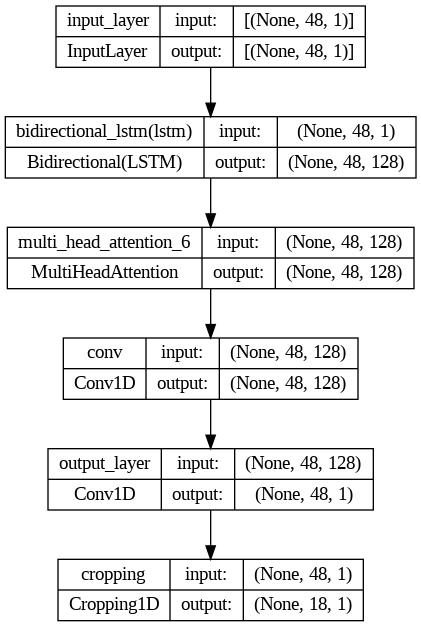

In [ ]:
X_train_1 = np.expand_dims(X_train_1, axis=-1)
X_val_1 = np.expand_dims(X_val_1, axis=-1)

y_train_1 = np.expand_dims(y_train_1, axis=-1)
y_val_1 = np.expand_dims(y_val_1, axis=-1)

input_shape  = X_train_1.shape[1:]
output_shape = y_train_1.shape[1:]
batch_size = 64
epochs = 200

model = build_CONV_LSTM_model(input_shape, output_shape)
model.summary()
tfk.utils.plot_model(model, expand_nested=True, show_shapes=True)

In [ ]:
history = model.fit(
    x = X_train_1,
    y = y_train_1,
    batch_size = batch_size,
    epochs = epochs,
    validation_data=(X_val_1, y_val_1),
    callbacks = [
        tfk.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=10, restore_best_weights=True,min_delta=1e-4),
        tfk.callbacks.ReduceLROnPlateau(monitor='val_loss', mode='min', patience=5, factor=0.5, min_lr=1e-5,min_delta=1e-4)
    ]
).history

Epoch 1/200
3418/3418 [==============================] - 41s 10ms/step - loss: 0.0663 - val_loss: 0.0595 - lr: 0.0020
Epoch 2/200
3418/3418 [==============================] - 34s 10ms/step - loss: 0.0603 - val_loss: 0.0588 - lr: 0.0020
Epoch 3/200
3418/3418 [==============================] - 35s 10ms/step - loss: 0.0587 - val_loss: 0.0582 - lr: 0.0020
Epoch 4/200
3418/3418 [==============================] - 34s 10ms/step - loss: 0.0575 - val_loss: 0.0561 - lr: 0.0020
Epoch 5/200
3418/3418 [==============================] - 34s 10ms/step - loss: 0.0568 - val_loss: 0.0566 - lr: 0.0020
Epoch 6/200
3418/3418 [==============================] - 35s 10ms/step - loss: 0.0561 - val_loss: 0.0592 - lr: 0.0020
Epoch 7/200
3418/3418 [==============================] - 37s 11ms/step - loss: 0.0556 - val_loss: 0.0580 - lr: 0.0020
Epoch 8/200
3418/3418 [==============================] - 36s 10ms/step - loss: 0.0552 - val_loss: 0.0559 - lr: 0.0020
Epoch 9/200
3418/3418 [==============================] -

In [ ]:
model.save('model_ascending')

In [ ]:
del model, input_shape, output_shape

##Model 3: descending

In [ ]:
X_train_2 = X_train_2.reshape(-1,48)
X_val_2 = X_val_2.reshape(-1,48)

y_train_2 = y_train_2.reshape(-1,18)
y_val_2 = y_val_2.reshape(-1,18)

Model: "CONV_LSTM_model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_layer (InputLayer)    [(None, 48, 1)]              0         []                            
                                                                                                  
 bidirectional_lstm (Bidire  (None, 48, 128)              33792     ['input_layer[0][0]']         
 ctional)                                                                                         
                                                                                                  
 multi_head_attention_5 (Mu  (None, 48, 128)              4248      ['bidirectional_lstm[0][0]',  
 ltiHeadAttention)                                                   'bidirectional_lstm[0][0]',  
                                                                     'bidirectional_

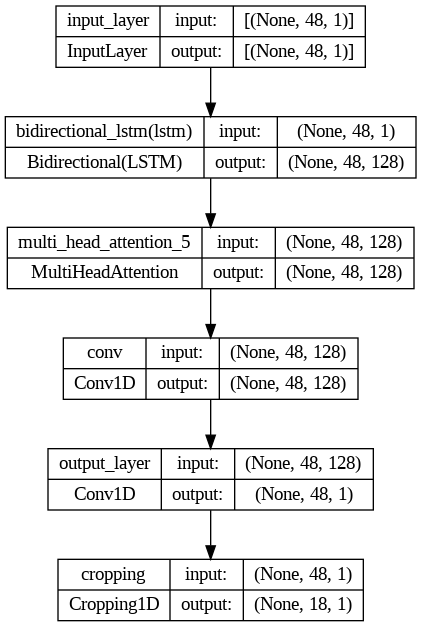

In [ ]:
X_train_2 = np.expand_dims(X_train_2, axis=-1)
X_val_2 = np.expand_dims(X_val_2, axis=-1)

y_train_2 = np.expand_dims(y_train_2, axis=-1)
y_val_2 = np.expand_dims(y_val_2, axis=-1)

input_shape  = X_train_2.shape[1:]
output_shape = y_train_2.shape[1:]
batch_size = 64
epochs = 200

model = build_CONV_LSTM_model(input_shape, output_shape)
model.summary()
tfk.utils.plot_model(model, expand_nested=True, show_shapes=True)

In [ ]:
history = model.fit(
    x = X_train_2,
    y = y_train_2,
    batch_size = 16,
    epochs = epochs,
    validation_data=(X_val_2, y_val_2),
    callbacks = [
        tfk.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=10, restore_best_weights=True,min_delta=1e-4),
        tfk.callbacks.ReduceLROnPlateau(monitor='val_loss', mode='min', patience=5, factor=0.5, min_lr=1e-5,min_delta=1e-4)
    ]
).history

Epoch 1/200
1443/1443 [==============================] - 21s 11ms/step - loss: 0.1184 - val_loss: 0.0952 - lr: 0.0020
Epoch 2/200
1443/1443 [==============================] - 15s 10ms/step - loss: 0.0972 - val_loss: 0.0964 - lr: 0.0020
Epoch 3/200
1443/1443 [==============================] - 15s 11ms/step - loss: 0.0935 - val_loss: 0.0984 - lr: 0.0020
Epoch 4/200
1443/1443 [==============================] - 15s 10ms/step - loss: 0.0918 - val_loss: 0.0902 - lr: 0.0020
Epoch 5/200
1443/1443 [==============================] - 15s 10ms/step - loss: 0.0900 - val_loss: 0.0907 - lr: 0.0020
Epoch 6/200
1443/1443 [==============================] - 16s 11ms/step - loss: 0.0890 - val_loss: 0.0861 - lr: 0.0020
Epoch 7/200
1443/1443 [==============================] - 15s 10ms/step - loss: 0.0880 - val_loss: 0.0883 - lr: 0.0020
Epoch 8/200
1443/1443 [==============================] - 17s 12ms/step - loss: 0.0871 - val_loss: 0.0890 - lr: 0.0020
Epoch 9/200
1443/1443 [==============================] -

In [ ]:
model.save('model_descending')

In [ ]:
del model, input_shape, output_shape

Based on the 3 clusters, 3 models are built: the ‘ascending’ model performs very well, while the other two are less powerful. Regarding the descending model it could be due to the small size of the training set (less than a half series with respect to the ascending group), while the irregular patterns may be less easy to learn because of their nature.

# Test

Just for showing as it should be on CodaLab, let's take a fake test set as the first 60 validation series, and consider just their last 200 values (as will be the real test set).

At testing time, test series need to be represented as well by their hidden vectors, which are built as usual with the embedding model on the last 48 values of each series; based on these, test samples are assigned to the closest cluster by `KNN` (`k=19`); then, the corresponding model will be used for prediction.

In [ ]:
test = series_val[0:60, -200:]
cluster_test = test[:, -48:]
cluster_model = tfk.models.load_model('model_embedding_test')
tens = cluster_model.predict(cluster_test, batch_size = 32, verbose=0)

In [ ]:
y_KNN = np.load('KNN_y.npy')
x_KNN = np.load('KNN_x.npy')

In [ ]:
model_0 = tfk.models.load_model('model_medium')
model_1 = tfk.models.load_model('model_ascending')
model_2 = tfk.models.load_model('model_descending')

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
model = KNeighborsClassifier(n_neighbors=19)
model.fit(x_KNN, y_KNN)

cluster = model.predict(tens)

In [ ]:
idx_0 = np.where(cluster == 0)
idx_1 = np.where(cluster == 1)
idx_2 = np.where(cluster == 2)

out = np.zeros((test.shape[0],18))
if len(idx_0[0])>0:
  out[idx_0[0],:] = np.squeeze(model_0.predict(test[idx_0[0], -48:]))
if len(idx_1[0])>0:
  out[idx_1[0],:] = np.squeeze(model_1.predict(test[idx_1[0], -48:]))
if len(idx_2[0])>0:
  out[idx_2[0],:] = np.squeeze(model_2.predict(test[idx_2[0], -48:]))

out = out[:, 0:9]

1/1 [==============================] - 0s 32ms/step


In [ ]:
print(idx_0[0].shape)
print(idx_1[0].shape)
print(idx_2[0].shape)

(20,)
(24,)
(16,)


In [ ]:
y_test = test[:, -9:]
# Print the shape of the predictions
print(f"Predictions shape: {out.shape}")

# Calculate and print Mean Squared Error (MSE)
mean_squared_error = tfk.metrics.mean_squared_error(y_test.flatten(), out.flatten()).numpy()
print(f"Mean Squared Error: {mean_squared_error}")

# Calculate and print Mean Absolute Error (MAE)
mean_absolute_error = tfk.metrics.mean_absolute_error(y_test.flatten(), out.flatten()).numpy()
print(f"Mean Absolute Error: {mean_absolute_error}")

Predictions shape: (60, 9)
Mean Squared Error: 0.015370070398754654
Mean Absolute Error: 0.08793035652505926


## `model.py`

In [ ]:
%%writefile model.py
import os
import tensorflow as tf
import numpy as np
from sklearn.neighbors import KNeighborsClassifier

class model:
    def __init__(self, path):
        # Load three different models and a clustering model from the specified path
        self.model_0 = tf.keras.models.load_model(os.path.join(path, 'SubmissionModel', 'model_medium'))
        self.model_1 = tf.keras.models.load_model(os.path.join(path, 'SubmissionModel', 'model_ascending'))
        self.model_2 = tf.keras.models.load_model(os.path.join(path, 'SubmissionModel', 'model_descending'))
        self.cluster_model = tf.keras.models.load_model(os.path.join(path, 'SubmissionModel', 'model_embedding_test'))

        # Load KNN data for later use
        self.X_KNN = np.load(os.path.join(path, 'KNN_Data', 'KNN_x.npy'))
        self.y_KNN = np.load(os.path.join(path, 'KNN_Data', 'KNN_y.npy'))

    def predict(self, X, categories):
        # Extract the last 48 elements from the input as cluster_test
        cluster_test = X[:, -48:]
        # Obtain hidden vectors using the cluster model
        hidden_vectors = self.cluster_model.predict(cluster_test, batch_size=32, verbose=0)

        # Create a KNN model, fit it with pre-loaded data, and predict clusters for hidden vectors
        KNN_model = KNeighborsClassifier(n_neighbors=19)
        KNN_model.fit(self.X_KNN, self.y_KNN)
        cluster = KNN_model.predict(hidden_vectors)

        # Separate indices based on cluster predictions
        idx_0 = np.where(cluster == 0)
        idx_1 = np.where(cluster == 1)
        idx_2 = np.where(cluster == 2)

        # Initialize an output array
        out = np.zeros((X.shape[0], 18))

        # Populate the output array based on the cluster indices
        if len(idx_0[0]) > 0:
            out[idx_0[0], :] = np.squeeze(self.model_0.predict(X[idx_0[0], -48:]))
        if len(idx_1[0]) > 0:
            out[idx_1[0], :] = np.squeeze(self.model_1.predict(X[idx_1[0], -48:]))
        if len(idx_2[0]) > 0:
            out[idx_2[0], :] = np.squeeze(self.model_2.predict(X[idx_2[0], -48:]))

        # Reshape the output array
        out = out.reshape(-1, 18)

        return out


Writing model.py
